# **어떤 뉴스가 시총 Top20 종목 주가의 등락을 결정하는가**

---

 ### 소주제) 코로나 이후로 부정적인 뉴스의 영향력이 커졌을 것이다.  
 ### 가설) 부정적인 뉴스가 주가 하락에 큰 영향을 줄 것이다.

- 기간: 2019.01.01 ~ 2020.11.01

- 방법론: 네이버 종목뉴스 감성분석(새끼뉴스까지)
- 변수: BusinessTimes Sentiment, 네이버 종목뉴스 감성분석 긍정/부정/중립
    
#### 뉴스의 영향력
- 코로나 전 후 비교 → *Q1. 2020년 1월 기준 vs 2020년 3월 기준*
- *Q2. 영향력을 나타내는 지표가 있는가?*
- 지표 후보
    1. 순매도(부정적 뉴스)
    2. 변동성: H-L %
    3. MA(): 코로나 전 = MA(20), 코로나 후 = MA(%)
    4. 개인투자자비율, 개인투자자금 비율: 기관투자의 움직임 고정 가정
- *Q3. 긍정/부정 뉴스의 영향력 비교가 가능한가?*


In [ ]:
pip install finance-datareader

In [ ]:
#  import FinanceDataReader as fdr
import pandas as pd
import time

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
top20 = pd.read_csv("/content/drive/Shared drives/2020-2 경제학특강4/financedata.csv").head(20)

top20

,순위,종목코드,종목명,현재가,대비,등락률,거래량,거래대금,시가,고가,저가,시가총액,시가총액비중(%),상장주식수,외국인 보유주식수,외국인 지분율(%),총카운트
0,1,005930,삼성전자,"60,300","1,800",3.1,"20,639,475","1,232,654,470,000","59,000","60,300","58,800","359,977,887,765,000",18.10,"5,969,782,550",NaN,NaN,2506.0
1,2,000660,SK하이닉스,"86,100","2,900",3.5,"4,082,325","348,613,876,600","84,100","86,200","83,300","62,681,003,626,500",3.15,"728,002,365",NaN,NaN,NaN
2,3,207940,삼성바이오로직스,"781,000","48,000",6.6,"447,218","347,396,415,000","767,000","787,000","757,000","51,674,865,000,000",2.60,"66,165,000",NaN,NaN,NaN
3,4,035420,NAVER,"299,000",500,0.2,"1,082,388","320,599,626,000","295,000","302,000","291,500","49,114,755,105,000",2.47,"164,263,395",NaN,NaN,NaN
4,5,051910,LG화학,"677,000","27,000",4.2,"446,583","298,622,140,000","663,000","677,000","656,000","47,791,016,211,000",2.40,"70,592,343",NaN,NaN,NaN
5,6,005935,삼성전자우,"53,500","1,300",2.5,"2,026,073","107,478,510,900","52,400","53,500","52,400","44,024,438,450,000",2.21,"822,886,700",NaN,NaN,NaN
6,7,005380,현대차,"175,000","3,500",2.0,"1,299,430","226,049,073,000","173,500","175,000","172,500","37,391,932,725,000",1.88,"213,668,187",NaN,NaN,NaN
7,8,068270,셀트리온,"272,000","1,500",0.6,"965,754","261,672,821,000","273,000","274,000","266,500","36,718,296,736,000",1.85,"134,993,738",NaN,NaN,NaN
8,9,006400,삼성SDI,"484,000","24,500",5.3,"727,072","347,585,233,816","472,000","484,000","466,500","33,282,032,520,000",1.67,"68,764,530",NaN,NaN,NaN
9,10,035720,카카오,"363,000","3,500",1.0,"1,061,367","382,380,889,000","359,000","368,500","353,000","32,033,958,297,000",1.61,"88,247,819",NaN,NaN,NaN


In [ ]:
# START_DATE = '2019-01-01'
START_DATE = '2019-12-01'
END_DATE = '2020-11-01'

## News 제목 수집

### 1) Finance.naver.com

In [ ]:
def NaverFinance_news(i):
# i = 0

    url = "https://finance.naver.com/item/news.nhn?code=%s" %top20['종목코드'][i]

    driver = webdriver.Chrome("./chromedriver")
    driver.get(url)
    time.sleep(1)

    print("------ %s(%s) crawling ------" %(top20['종목명'][i], top20['종목코드'][i]))

    end = datetime.datetime.strptime(END_DATE, "%Y-%m-%d")
    print("...START")
    page = 2
    next_ = 0

    news_title = []
    news_date = []

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    driver.switch_to.frame('news')

    while (end >= datetime.datetime.strptime(START_DATE, "%Y-%m-%d")):

        hiddennews = driver.find_elements_by_css_selector("tbody td > div > a")

        for hn in hiddennews:
            hn.click()

        title = [t.text for t in driver.find_elements_by_css_selector("td.title")]
        date = [datetime.datetime.strptime(d.text, '%Y.%m.%d %H:%M') for d in driver.find_elements_by_css_selector("td.date")]
        end = date[-1]

        for tt in date:
            if tt <= datetime.datetime.strptime(END_DATE, "%Y-%m-%d"):
                news_title.append(title[date.index(tt)])
                news_date.append(tt)

    #page: nth(2) 2페이지 > nth(4) 3페이지 ~ nth(11) 10페이지 > nth(12) = 다음 
    #      > nth(4) 12페이지 ~ nth(12) 20페이지 > nth(13) = 다음
    #      > [반복]
    #     print("page tr:nth-child:", page)
        if (page == 2 and next_ == 0):
            page_more = driver.find_element_by_css_selector("body > div > table.Nnavi > tbody > tr > td:nth-child(%d) > a" %(page))
    #         page_more.click()
            page = 3

        elif (page == 12 and next_ == 0) or (page == 13 and next_ > 0):
            page_more = driver.find_element_by_css_selector("body > div > table.Nnavi > tbody > tr > td.pgR > a")
            next_ += 1
            page = 3

        else:
            page_more = driver.find_element_by_css_selector("body > div > table.Nnavi > tbody > tr > td:nth-child(%d) > a" %(page))

    #     print("CLICK:", page_more.text, "페이지, 다음 누른 횟수:", next_)
        page_more.click()
        page += 1



    print("total:", len(news_title))
    print("last date:", news_date[-1])

    print("Saving")
    df = pd.DataFrame({"Date": news_date, "Title": news_title})
    df.to_csv("%s_NaverFinance.csv" %top20['종목명'][i])
    
    print("DONE...")
    driver.close()

In [ ]:
for i in range(len(top20)):
    NaverFinance_news(i)

------ 삼성전자(005930) crawling ------
...START
total: 17010
last date: 2020-07-03 08:14:00
Saving
DONE...
------ SK하이닉스(000660) crawling ------
...START
total: 2340
last date: 2019-11-12 15:50:00
Saving
DONE...
------ 삼성바이오로직스(207940) crawling ------
...START
total: 1133
last date: 2019-11-14 14:00:00
Saving
DONE...
------ NAVER(035420) crawling ------
...START
total: 4191
last date: 2019-11-11 08:49:00
Saving
DONE...
------ LG화학(051910) crawling ------
...START
total: 4732
last date: 2019-11-13 14:01:00
Saving
DONE...
------ 삼성전자우(005935) crawling ------
...START
total: 55
last date: 2019-11-18 18:37:00
Saving
DONE...
------ 현대차(005380) crawling ------
...START
total: 10533
last date: 2020-02-28 11:33:00
Saving
DONE...
------ 셀트리온(068270) crawling ------
...START
total: 2177
last date: 2019-11-10 09:48:00
Saving
DONE...
------ 삼성SDI(006400) crawling ------
...START
total: 923
last date: 2019-11-17 10:52:00
Saving
DONE...
------ 카카오(035720) crawling ------
...START
total: 2658
last date:

### 2) Naver News

In [ ]:
START_DATE = '2020-02-28'
END_DATE = '2020-07-02'

In [ ]:
url = "https://search.naver.com/search.naver?where=news&query=삼성전자&sm=tab_opt&sort=0&photo=0&field=0&reporter_article=&pd=3&ds=%s&de=%s" %(START_DATE.replace('-', '.'), END_DATE.replace("-", "."))

driver = webdriver.Chrome("./chromedriver")
driver.get(url)
driver.implicitly_wait(2)

# date = datetime.datetime.strptime(END_DATE, "%Y-%m-%d")
date = END_DATE.replace("-", ".") + "."

Title = []
Date = []
page_btn = 1

while datetime.datetime.strptime(date, "%Y.%m.%d.") >= datetime.datetime.strptime(START_DATE, "%Y-%m-%d"):
    
    driver.find_element_by_css_selector("div.sc_page_inner > a:nth-child(%d)" %page_btn).click()
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    # 뉴스 한 칸씩 수집
    size = len(driver.find_elements_by_css_selector("ul.list_news > li"))
#     n = 1

    for n in range(1, size):
        
        try:
            # 관련기사 더보기 있음
            driver.find_element_by_css_selector("ul.list_news > li:nth-child(%d) a.news_more" %n).click()
            
            sc_page = len(driver.find_elements_by_css_selector("div.sc_page_inner > a"))
            sc = 1

            while sc < sc_page:
                # related news
                for r in range(1, size):
                    title = driver.find_element_by_css_selector("ul.list_news > li:nth-child(%d) div.news_area > a.news_tit" %r).text
                    Title.append(title)
                    date = driver.find_element_by_css_selector("ul.list_news > li:nth-child(%d) div.news_info span.info" %r).text
                    try:
                        Date.append(datetime.datetime.strptime(date, "%Y.%m.%d."))
                    except:
                        date = driver.find_element_by_css_selector("ul.list_news > li:nth-child(%d) div.news_info span.info" %(r+1)).text
                        Date.append(datetime.datetime.strptime(date, "%Y.%m.%d."))

                sc += 1
                # 관련기사 다음페이지
                driver.find_element_by_css_selector("#main_pack > div.api_sc_page_wrap > div > div > a:nth-child(%d)" %(sc)).click()
            
            if sc == sc_page:
                driver.find_element_by_css_selector("div.api_tab_option_wrap > div > a").click() # 전체뉴스검색 돌아가기
                driver.find_element_by_css_selector("div.sc_page_inner > a:nth-child(%d)" %page_btn).click() # 원래 있었던 페이지로 돌아가기
        
        except:
            # 관련기사 더보기 없음
            title = driver.find_element_by_css_selector("ul.list_news > li:nth-child(%d) a.news_tit" %n).text
            Title.append(title)
            date = driver.find_element_by_css_selector("ul.list_news > li:nth-child(%d) span.info" %n).text
            try:
                Date.append(datetime.datetime.strptime(date, "%Y.%m.%d."))
            except:
                date = driver.find_element_by_css_selector("ul.list_news > li:nth-child(%d) span.info" %(n+1)).text
                Date.append(datetime.datetime.strptime(date, "%Y.%m.%d."))
    
    page_btn += 1


---
## 뉴스 제목 감성분석

### 뉴스 제목 번역
1. 한→영
2. 한→일→영

In [ ]:
pip install googletrans

In [ ]:
from google.colab import files

In [ ]:
for t in range(len(top20['종목명'])):
  data = pd.read_csv("/content/gdrive/Shared drives/2020-2 경제학특강4/NaverFinance/%s_NaverFinance.csv" %top20['종목명'][t], encoding = 'UTF-8').drop(columns = 'Unnamed: 0')

  from googletrans import Translator

  eng = []
  
  for i in range(len(data.Title)):
    tl = Translator()
    result = tl.translate(data['Title'][i], dest = "en", src = 'ko').text
    eng.append(result)
    time.sleep(30)

  data['EngTitle'] = eng


  data.to_csv("%s_Trans.csv" %top20['종목명'][t], index = False)
  files.download("%s_Trans.csv" %top20['종목명'][t])

AttributeError: ignored

In [ ]:
data

,Date,Title
0,2020-10-31 17:11:00,"삼성 하반기 GSAT 첫날 종료…""난이도 상반기보다 낮아"""
1,2020-10-31 16:43:00,"삼성 GSAT 온라인 진행.. ""난이도 평이했다"""
2,2020-10-31 16:34:00,"하반기 온라인 삼성직무적성검사 첫날…응시자들 ""불GSAT 없었다"""
3,2020-10-31 14:09:00,"삼성 하반기 GSAT 실시…""상반기 '불수능'보다 훨씬 쉬웠다"""
4,2020-10-31 13:44:00,삼성 하반기 GSAT 온라인 시행…상반기보다 원활히 진행
...,...,...
17005,2020-07-03 09:50:00,"""삼성, 갤럭시Z 플립 5G ‘미스틱 브론즈’ 색상 출시"""
17006,2020-07-03 09:39:00,"""LTE노트북 2년쓰고 최대 50%보상""...KT, 삼성 노트북 '갤럭..."
17007,2020-07-03 09:12:00,"삼성준법위, 22일 첫 워크숍..자유토론 방식"
17008,2020-07-03 09:09:00,"삼성전자, 2분기 실적 '예상치 상회'..목표가↑-IBK투자증권"


In [ ]:
pip install googletrans

In [ ]:
from googletrans import Translator

In [ ]:
t = 0
data = pd.read_csv("/content/gdrive/Shared drives/2020-2 경제학특강4/NaverFinance/%s_NaverFinance.csv" %top20['종목명'][t], encoding = 'UTF-8').drop(columns = 'Unnamed: 0')

tl = Translator()
eng = []
for e in range(len(data.Title)):
  result = tl.translate(data.Title[e], dest = "en", src = 'ko').text
  eng.append(result)

data['EngTitle'] = eng

AttributeError: ignored

In [ ]:
data

,Date,Title,EngTitle
0,2020-10-31 15:56:00,'수소경제 첨병' 현대차그룹…넥쏘 1만대 돌파에 文대통령도 박수,'Hydrogen Economy Leader' Hyundai Motor Group....
1,2020-10-31 15:10:00,"한신평 ""현대종합특수강 유증 재무구조에 긍정적, 신용도 부담은 여전""","Shinpyeong Han ""Hyundai Special Steel bequests..."
2,2020-10-31 09:12:00,"수소시대 투자는 현대차만? 전문가들 ""이런 기업 주목해야""",Only Hyundai Motor Company is investing in the...
3,2020-10-31 08:43:00,"문재인 대통령, 정의선 현대차 회장에 ""우리 회장님""···왜?",President Moon Jae-in and Hyundai Motor Chairm...
4,2020-10-30 17:33:00,[단독] CNN 캠페인 등장한 정의선…현대차 `모빌리티 혁신` 강조,[Exclusive] Eui-seon Eui-sun appeared in the C...
...,...,...,...
10528,2020-02-28 11:57:00,"현대차서 첫 코로나19 확진자 나와…울산 2공장 가동 중단, 방역 실시",Hyundai Motor Company's first corona19 confirm...
10529,2020-02-28 11:18:00,[속보]현대차 울산공장 직원 코로나19 확진,[Breaking News] Hyundai Motor Company's Ulsan ...
10530,2020-02-28 11:48:00,"현대차 울산2공장, 코로나19 확진자 발생..가동 중단(상보)","Hyundai Motor Company's Ulsan Plant 2, COVID-1..."
10531,2020-02-28 11:38:00,"현대차, 낙폭 확대…울산2공장 직원 코로나19 확진에 가동 중단",Hyundai Motors expands its decline... Ulsan Pl...


In [ ]:
data.to_csv("%s_Trans.csv" %top20['종목명'][t], index = False)
files.download("%s_Trans.csv" %top20['종목명'][t])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 뉴스 전처리 및 감성분석

#### 1) 감성사전을 이용한 지도학습
- [솜씨좋은장씨](https://somjang.tistory.com/entry/Keras기사-제목을-가지고-긍정-부정-중립-분류하는-모델-만들어보기)

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [7]:
pos = pd.read_excel("/content/drive/Shared drives/2020-2 경제학특강4/뉴스 제목 번역/Word list/Positive.xlsx")
positive = list(pos.words.apply(lambda x: x.lower()))

neg = pd.read_excel("/content/drive/Shared drives/2020-2 경제학특강4/뉴스 제목 번역/Word list/Negative.xlsx")
negative = list(neg.words.apply(lambda x: x.lower()))

neu = pd.read_excel("/content/drive/Shared drives/2020-2 경제학특강4/뉴스 제목 번역/Word list/Uncertainty.xlsx")
neutral = list(neu.words.apply(lambda x: x.lower()))

posneg = positive + negative + neutral

In [ ]:
i

1968

In [16]:
for k in range(0, 1):
  tick = top20['종목명'][k]
  data = pd.read_csv("/content/drive/Shared drives/2020-2 경제학특강4/뉴스 제목 번역/%s_Trans.csv" %tick)[['Date', 'EngTitle']]

  label = []
  title_label = {"title": [], "token": [], 'label': label}


  for t in data.EngTitle:
      pos_c = 0
      neg_c = 0
      neu_c = 0
  #     t = tl.translate(t, dest = "en").text
      t = re.sub('[^a-zA-Z#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…\"\“》]', ' ', t)
      title_label['title'].append(t)
      
      t = data_text_cleaning(t)
      title_label['token'].append(t)
      t = ' '.join(t)
      
      for i in range(len(posneg)):
          if i < len(positive):
              if t.find(posneg[i]) != -1:
                  pos_c += 1
          elif i >= len(positive):
              if t.find(posneg[i]) != -1:
                  neg_c += 1
          elif i >= len(positive+negative):
              if t.find(posneg[i]) != -1:
                  neu_c += 1
          
      if pos_c > neg_c:
          label.append(1)
      elif pos_c < neg_c:
          label.append(-1)
      elif max(pos_c, neg_c, neu_c) == neu_c or pos_c == neg_c:
          label.append(0)
  #     else:
  #         label.append(100)
  #         print(t, pos_c, neg_c, neu_c)
          
  #     print(t, pos_c, neg_c, neu_c)

  title_label['label'] = label

  Title = pd.DataFrame(title_label)
  data['Title_token'] = title_label['token']
  data['posneg'] = title_label['label']

  for i in range(len(data)):
    if len(data.Title_token[i]) >= 0 and len(data.Title_token[i]) <= 3:
        data.drop([i], inplace = True)

  train_data = data[data.Date < '2020-09-01']
  test_data = data[data.Date >= '2020-09-01']

  print(train_data.groupby('posneg').size().reset_index(name='count')) 
  print(test_data.groupby('posneg').size().reset_index(name='count'))

  X_train = train_data.Title_token
  X_test = test_data.Title_token

  from keras.preprocessing.text import Tokenizer

  max_words = 35000 # ?
  tokenizer = Tokenizer(num_words = max_words)
  tokenizer.fit_on_texts(X_train)
  X_train = tokenizer.texts_to_sequences(X_train)
  X_test = tokenizer.texts_to_sequences(X_test)


  # One-hot encoding
  import numpy as np

  y_train = []
  y_test = []

  for i in range(len(train_data['posneg'])):
      if train_data['posneg'].iloc[i] == 1:
          y_train.append([0, 0, 1])
      elif train_data['posneg'].iloc[i] == 0:
          y_train.append([0, 1, 0])
      elif train_data['posneg'].iloc[i] == -1:
          y_train.append([1, 0, 0])

          
  for i in range(len(test_data['posneg'])):
      if test_data['posneg'].iloc[i] == 1:
          y_test.append([0, 0, 1])
      elif test_data['posneg'].iloc[i] == 0:
          y_test.append([0, 1, 0])
      elif test_data['posneg'].iloc[i] == -1:
          y_test.append([1, 0, 0])

  y_train = np.array(y_train)
  y_test = np.array(y_test)

  # Model 쌓기
  from keras.layers import Embedding, Dense, LSTM, Bidirectional, SimpleRNN
  from keras.models import Sequential
  from keras.preprocessing.sequence import pad_sequences 

  max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
  X_train = pad_sequences(X_train, maxlen=max_len) 
  X_test = pad_sequences(X_test, maxlen=max_len)

  import tensorflow as tf

  tf.keras.backend.clear_session()

  # model = Sequential()
  # model.add(Embedding(max_words, 100))
  # # model.add(SimpleRNN(128))
  # model.add(LSTM(128))

  # model.add(Dense(3, activation = 'softmax'))

  # model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  # history = model.fit(X_train, y_train, epochs = 10, batch_size = 10, validation_split = 0.1, verbose=0)
  model = Sequential()
  model.add(LSTM(32,return_sequences=True))
  model.add(LSTM(32))
  model.add(LSTM(32))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs = 10, batch_size = 10, validation_split = 0.1)

  acc_loss_plot(key[k], history)

   posneg  count
0      -1   1622
1       0   5757
2       1    596
   posneg  count
0      -1    495
1       0   1243
2       1    231
Epoch 1/10


ValueError: ignored

In [ ]:
len(key)

19

In [ ]:
acc_loss_plot(key[k], history)

IndexError: ignored

In [11]:
def data_text_cleaning(data):
 
    # 영문자 이외 문자는 공백으로 변환
    only_english = re.sub('[^a-zA-Z]', ' ', data)
 
    # 소문자 변환
    no_capitals = only_english.lower().split()
 
    # 불용어 제거
    stops = set(stopwords.words('english'))
    no_stops = [word for word in no_capitals if not word in stops]
 
    # 어간 추출
    stemmer = nltk.stem.SnowballStemmer('english')
    stemmer_words = [stemmer.stem(word) for word in no_stops]
 
    # 공백으로 구분된 문자열로 결합하여 결과 반환
    return stemmer_words

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
label = []
title_label = {"title": [], "token": [], 'label': label}


for t in data.EngTitle:
    pos_c = 0
    neg_c = 0
    neu_c = 0
#     t = tl.translate(t, dest = "en").text
    t = re.sub('[^a-zA-Z#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…\"\“》]', ' ', t)
    title_label['title'].append(t)
    
    t = data_text_cleaning(t)
    title_label['token'].append(t)
    t = ' '.join(t)
    
    for i in range(len(posneg)):
        if i < len(positive):
            if t.find(posneg[i]) != -1:
                pos_c += 1
        elif i >= len(positive):
            if t.find(posneg[i]) != -1:
                neg_c += 1
        elif i >= len(positive+negative):
            if t.find(posneg[i]) != -1:
                neu_c += 1
        
    if pos_c > neg_c:
        label.append(1)
    elif pos_c < neg_c:
        label.append(-1)
    elif max(pos_c, neg_c, neu_c) == neu_c or pos_c == neg_c:
        label.append(0)
#     else:
#         label.append(100)
#         print(t, pos_c, neg_c, neu_c)
        
#     print(t, pos_c, neg_c, neu_c)

title_label['label'] = label

In [ ]:
Title = pd.DataFrame(title_label)

In [ ]:
data['Title_token'] = title_label['token']
data['posneg'] = title_label['label']

In [ ]:
for i in range(len(data)):
    if len(data.Title_token[i]) >= 0 and len(data.Title_token[i]) <= 3:
        data.drop([i], inplace = True)

- 2019.12.01 ~ 2020.08.31 : train
- 2020.09.01 ~            : test

In [ ]:
train_data = data[data.Date < '2020-09-01']
test_data = data[data.Date >= '2020-09-01']

print(train_data.groupby('posneg').size().reset_index(name='count')) 
print(test_data.groupby('posneg').size().reset_index(name='count'))

   posneg  count
0      -1   1622
1       0   5757
2       1    596
   posneg  count
0      -1    495
1       0   1243
2       1    231


In [ ]:
X_train = train_data.Title_token
X_test = test_data.Title_token

In [ ]:
from keras.preprocessing.text import Tokenizer

max_words = 35000 # ?
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

제목의 최대 길이 :  19
제목의 평균 길이 :  8.38319749216301


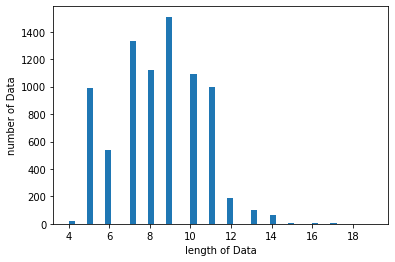

제목의 최대 길이 :  17
제목의 평균 길이 :  8.414423565261554


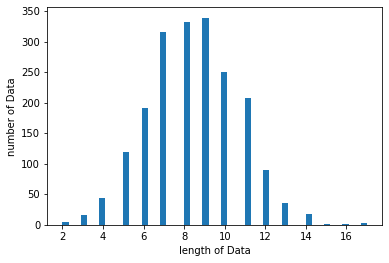

In [ ]:
import matplotlib.pyplot as plt

print("제목의 최대 길이 : ", max(len(l) for l in X_train)) 
print("제목의 평균 길이 : ", sum(map(len, X_train))/ len(X_train)) 

plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

print("제목의 최대 길이 : ", max(len(l) for l in X_test)) 
print("제목의 평균 길이 : ", sum(map(len, X_test))/ len(X_test)) 

plt.hist([len(s) for s in X_test], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

In [ ]:
# One-hot encoding
import numpy as np

y_train = []
y_test = []

for i in range(len(train_data['posneg'])):
    if train_data['posneg'].iloc[i] == 1:
        y_train.append([0, 0, 1])
    elif train_data['posneg'].iloc[i] == 0:
        y_train.append([0, 1, 0])
    elif train_data['posneg'].iloc[i] == -1:
        y_train.append([1, 0, 0])

        
for i in range(len(test_data['posneg'])):
    if test_data['posneg'].iloc[i] == 1:
        y_test.append([0, 0, 1])
    elif test_data['posneg'].iloc[i] == 0:
        y_test.append([0, 1, 0])
    elif test_data['posneg'].iloc[i] == -1:
        y_test.append([1, 0, 0])

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Model 쌓기
from keras.layers import Embedding, Dense, LSTM, Bidirectional, SimpleRNN
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences 

max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)  

In [1]:
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

NameError: ignored

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, 100))
# model.add(SimpleRNN(128))
model.add(LSTM(128))

model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 10, batch_size = 10, validation_split = 0.1)

Epoch 1/10
718/718 [==============================] - 28s 39ms/step - loss: 0.2082 - accuracy: 0.9221 - val_loss: 0.7272 - val_accuracy: 0.7343
Epoch 2/10
718/718 [==============================] - 27s 37ms/step - loss: 0.0999 - accuracy: 0.9659 - val_loss: 0.7549 - val_accuracy: 0.7531
Epoch 3/10
718/718 [==============================] - 27s 37ms/step - loss: 0.0561 - accuracy: 0.9833 - val_loss: 0.9371 - val_accuracy: 0.8246
Epoch 4/10
718/718 [==============================] - 27s 37ms/step - loss: 0.0346 - accuracy: 0.9907 - val_loss: 0.6283 - val_accuracy: 0.8446
Epoch 5/10
718/718 [==============================] - 27s 37ms/step - loss: 0.0234 - accuracy: 0.9935 - val_loss: 0.6449 - val_accuracy: 0.8459
Epoch 6/10
718/718 [==============================] - 27s 38ms/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.8424 - val_accuracy: 0.7456
Epoch 7/10
718/718 [==============================] - 27s 38ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 1.0231 - val_accuracy:

In [ ]:
def acc_loss_plot(tick, hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history['loss'], 'r--', label = 'train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')
    
    acc_ax.plot(hist.history['accuracy'], 'b--', label = 'train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'b', label = 'val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc = 'upper right')
    
    plt.title("%s Label (%.2f%%)" %(tick, model.evaluate(X_test, y_test)[1] * 100))
    plt.savefig("/content/drive/Shareddrives/2020-2 경제학특강4/%s Label.png" %tick)
    plt.show()

In [ ]:
print("Test accuracy : %.2f" %(model.evaluate(X_test, y_test)[1] * 100))

62/62 [==============================] - 1s 8ms/step - loss: 1.3838 - accuracy: 0.8116
Test accuracy : 81.16


In [ ]:
key = ['Samsung Electronics', 'SK Hynix', 'Samsung Biologics', 'Naver', 'LG Chem', "Samsung Electronics Woo", 'Hyundai Motor', 'Celltrion', 'Samsung SDI', 'Kakao', 'LG health', 
       'Hyundai Mobis', 'Samsung C&T', 'KIA Motors', 'Posco', 'NCsoft', 'SK Telecom', 'KB', 'Shinhan', 'LG Electronics']

62/62 [==============================] - 0s 8ms/step - loss: 1.3838 - accuracy: 0.8116


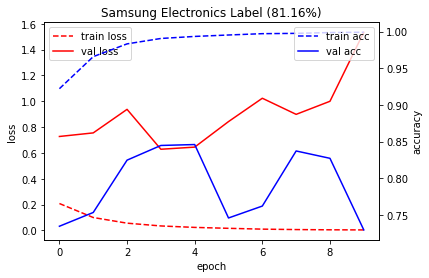

In [ ]:
acc_loss_plot(key[0], history)

- [전처리](https://myjamong.tistory.com/77)
- [텍스트 분류](https://techblog-history-younghunjo1.tistory.com/111)

#### 2) 감성어휘사전을 이용한 비지도학습
- nltk.vader

In [ ]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def get_sentiment(title, threshold):
    final_sentiment = 0
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(title)
    # print(scores)
    
    compound_score = scores['compound']
    if compound_score >= threshold: 
        final_sentiment = 1
    elif compound_score <= -threshold:
        final_sentiment = -1
    else: final_sentiment = 0
#     final_sentiment = 1 if compound_score >= threshold else 0
    return final_sentiment

Dividend attractive ↑… Samsung Electronics' preferred stock, stronger than common stock
- after cleaning: {'neg': 0.0, 'neu': 0.579, 'pos': 0.421, 'compound': 0.6249}
- before cleaning: 
{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'compound': 0.6705}

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

data['vader_pred'] = data.EngTitle.apply(lambda x: get_sentiment(x, 0.01))

In [ ]:
data

,Date,EngTitle,Title_token,posneg,vader_pred
0,2020-10-31 09:07:00,[Weekly HOT Stock] Kia Motors'focused' on surp...,"[week, hot, stock, kia, motor, focus, surplus,...",0,-1
1,2020-10-30 17:41:00,GM Korea union partial strike...Kia Motors als...,"[gm, korea, union, partial, strike, kia, motor...",0,0
2,2020-10-30 04:02:00,"Hyundai-Kia Motors, average 32 years of tradin...","[hyundai, kia, motor, averag, year, trade, per...",0,0
3,2020-10-29 15:17:00,"After Kia Motors, GM Korea will also go on str...","[kia, motor, gm, korea, also, go, strike, kore...",0,-1
4,2020-10-29 10:20:00,Labor and management of Kia Motors donated '9 ...,"[labor, manag, kia, motor, donat, ray, welfar,...",0,-1
...,...,...,...,...,...
4616,2019-11-12 09:08:00,Kia Motors' 3rd generation'new K5' model appea...,"[kia, motor, rd, generat, new, k, model, appear]",-1,-1
4617,2019-11-12 09:04:00,More boldly and more dynamic evolution… Kia Mo...,"[bold, dynam, evolut, kia, motor, unveil, rd, ...",0,1
4618,2019-11-12 08:47:00,Kia Motors Unveils 3rd Generation K5 Exterior....,"[kia, motor, unveil, rd, generat, k, exterior,...",0,-1
4619,2019-11-11 17:38:00,Li Feng “Hyundai·Kia Motors Needs 3 Years to R...,"[li, feng, hyundai, kia, motor, need, year, re...",0,0


---
## 뉴스의 영향력 평가
1. 개인, 기관, 외국인 투자자 비율 변화
  - 개인 투자자에 집중
2. ATR지수 
   <!-- $$avg(max(max(h-l,abs(c(1)-h)),abs(c(1)-l)),Period)$$ -->

   $$avg(max(h_t - l_{t}, |c_{t-1} - h_t|, |c_{t-1} - l_t|), Period)$$
  - TR: (당일고가 - 당일저가), (당일고가 - 전일종가) , (전일종가 - 당일저가) 중에 최대값
  - Period : 주로 14일
  - [처음해보는 블로그](https://mystorage1.tistory.com/525)
  - [신이내린 필살기, 보조지표 ATR 이야기](https://www.dogdrip.net/doc/234990589)


### 1. 투자자별 매매동향 데이터
- 개인 순매도량 = 기관 + 외국인 순매수량
- 거래량 = 체결된 거래의 수
- 거래량과 순매도량은 다를 수 있음.
- 개인 순매도량 계산해서 DF에 합치기
- 거래량 퍼센트로 변환?
- csv 파일 업로드 완료
- 개인매수증가율/개인매도증가율 계산 필요.
- 현대차, 삼성전자, NAVER ; Unnamed 칼럼 지우기

In [ ]:
 # 개인매수/개인매도/개인매수비율/개인매도비율/개인매수비율증분/개인매도비율증분 칼럼 추가
invdf = pd.read_csv("/content/gdrive/Shared drives/2020-2 경제학특강4/투자자별 거래량/카카오_투자자별거래량.csv")#.drop(columns=['Unnamed:11'])
invdf['개인 매수'] = invdf['거래량']-invdf['기관 매수']-invdf['외국인 매수']
invdf['개인 매도'] = invdf['거래량']-invdf['기관 매도']-invdf['외국인 매도']
invdf['개인매수비율(%)'] = (invdf['개인 매수']/invdf['거래량'])*100
invdf['개인매수비율증가(%p)'] = invdf['개인매수비율(%)']- invdf['개인매수비율(%)'].shift(1)
invdf['개인매도비율(%)'] = (invdf['개인 매도']/invdf['거래량'])*100
invdf['개인매도비율증가(%p)'] = invdf['개인매도비율(%)']- invdf['개인매도비율(%)'].shift(1)
Newdf = invdf
Newdf
Newdf.to_csv("/content/gdrive/Shared drives/2020-2 경제학특강4/투자자별 거래량/투자자별 거래량 편집본/카카오_투자자매매동향.csv")

,Unnamed: 0,날짜,종가,대비,거래량,기관 매수,기관 매도,기관 순매수,외국인 매수,외국인 매도,외국인 순매수,개인 순매수,Unnamed: 11,Unnamed: 12,개인 매수,개인 매도,개인매수비율(%),개인매수비율증가(%p),개인매도비율(%),개인매도비율증가(%p)
0,0,2020-11-11,"61,300","1,100",25628510,10408477,7892021,2516456,11505883,4013242,7492641,-10009097,NaN,NaN,3714150,13723247,14.492259,NaN,53.546800,NaN
1,1,2020-11-10,"60,200",0,19073552,9426666,11630302,-2203636,5397909,4456509,941400,1262236,NaN,NaN,4248977,2986741,22.276800,7.784541,15.659071,-37.887729
2,2,2020-11-09,"60,200",100,15892961,8354943,7342976,1011967,4850555,2715228,2135327,-3147294,NaN,NaN,2687463,5834757,16.909769,-5.367031,36.712838,21.053767
3,3,2020-11-06,"60,100",-200,16910230,8318707,8954209,-635502,5091351,2483093,2608258,-1972756,NaN,NaN,3500172,5472928,20.698548,3.788779,32.364598,-4.348240
4,4,2020-11-05,"60,300","1,800",20639475,9984962,7935436,2049526,8267046,1307283,6959763,-9009289,NaN,NaN,2387467,11396756,11.567479,-9.131068,55.218246,22.853647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,2019-11-14,"52,800",300,12010018,8262702,6747016,1515686,2927089,4288924,-1361835,-153851,NaN,NaN,820227,974078,6.829523,-0.579209,8.110546,-42.294860
246,246,2019-11-13,"52,500",-100,6225196,2331779,3470119,-1138340,3008205,2237778,770427,367913,NaN,NaN,885212,517299,14.219825,7.390302,8.309762,0.199217
247,247,2019-11-12,"52,600","1,000",6576148,2865792,2558517,307275,3060693,2975661,85032,-392307,NaN,NaN,649663,1041970,9.879081,-4.340744,15.844686,7.534924
248,248,2019-11-11,"51,600",-500,8185952,3582483,3730550,-148067,3147085,3608134,-461049,609116,NaN,NaN,1456384,847268,17.791260,7.912179,10.350268,-5.494418


### 2. ATR 지수
$$avg(max(h_t - l_{t}, |c_{t-1} - h_t|, |c_{t-1} - l_t|), Period)$$

In [ ]:
data = fdr.DataReader(top20['종목코드'][0], start = START_DATE, end = END_DATE)
data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-02-28,55000,55500,54200,54200,30054227,-0.030411
2020-03-02,54300,55500,53600,55000,30403412,0.014760
2020-03-03,56700,56900,55100,55400,30330295,0.007273
2020-03-04,54800,57600,54600,57400,24765728,0.036101
2020-03-05,57600,58000,56700,57800,21698990,0.006969
...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322
2020-10-27,60300,60300,59500,59800,17260416,-0.009934
2020-10-28,59400,59400,58800,59000,14428882,-0.013378


In [ ]:
import numpy as np

In [ ]:
# ATR(14) 계산

df = data
df['HL'] = df.High-df.Low; df['CH'] = df.Close.shift(1)-df.High; df['CL'] = df.Close.shift(1)-df.Low
df['absCH'] = np.abs(df['CH']); df['absCL'] = np.abs(df['CL'])
df1 = df.iloc[:,[6,9,10]]
df2 = pd.concat([data,df1.max(axis=1)],axis=1)
df2.columns = ['Open','High','Low','Close','Volume','Change','HL','CH','CL','ACH','ACL','TR']
df2['ATR_14'] = df2.TR.rolling(window=14).mean()
df3 = df2.iloc[:,[0,1,2,3,4,5,11,12]]
df3.head(20)

,Open,High,Low,Close,Volume,Change,TR,ATR_14
Date,,,,,,,,
2020-02-28,55000,55500,54200,54200,30054227,-0.030411,1300.0,NaN
2020-03-02,54300,55500,53600,55000,30403412,0.014760,1900.0,NaN
2020-03-03,56700,56900,55100,55400,30330295,0.007273,1900.0,NaN
2020-03-04,54800,57600,54600,57400,24765728,0.036101,3000.0,NaN
2020-03-05,57600,58000,56700,57800,21698990,0.006969,1300.0,NaN
2020-03-06,56500,57200,56200,56500,18716656,-0.022491,1600.0,NaN
2020-03-09,54700,55000,53600,54200,30261485,-0.040708,2900.0,NaN
2020-03-10,53800,54900,53700,54600,32106554,0.007380,1200.0,NaN
2020-03-11,54300,54400,52000,52100,45707281,-0.045788,2600.0,NaN


In [ ]:
# max([(data.High - data.Low), np.abs(data.Close.shift(1) - data.High), np.abs(data.Close.shift(1) - data.Low)])

ValueError: ignored

## 데이터 합치기

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

top20 = pd.read_csv("/content/drive/Shareddrives/2020-2 경제학특강4/financedata.csv").head(20)

In [ ]:
for tick in top20['종목명']:
  cls = pd.read_csv("/content/drive/Shareddrives/2020-2 경제학특강4/금융데이터/원본다운로드/%s_주가데이터.csv" %tick)[['Date', 'Close', 'Volume', 'Change', 'TR', 'ATR_14']]
  posneg = pd.read_csv("/content/drive/Shareddrives/2020-2 경제학특강4/긍정 부정 중립 Label/Label 원본/%s_label.csv" %tick)

  posneg.drop(columns = ['EngTitle', 'vader_pred'], inplace = True)
  new = []
  for date in posneg.Date:
    date = date.split(" ")[0]
    new.append(date)
  posneg['Date'] = new
  count = posneg.groupby(by = 'Date', as_index = False).count()[['Date', 'compound']].rename(columns = {'compound' : "count"})
  posneg = posneg.merge(count, how = 'left', on = 'Date')
  posneg = posneg.groupby(by = "Date", as_index = False).mean()

  invest = pd.read_csv("/content/drive/Shareddrives/2020-2 경제학특강4/투자자별 거래량/투자자별 거래량_최종/%s_투자자매매동향_기준일편집.csv" %tick)
  invest = invest[['날짜', '기관 매수', '기관 매도', '외국인 매수', '외국인 매도', '개인 매수', '개인 매도', '개인매수비율(%)',
       '개인매수비율증가(%p)', '개인매도비율(%)', '개인매도비율증가(%p)', '개인 순매수비율', '기관 순매수비율',
       '외국인 순매수비율']]
  invest = invest.rename(columns = {'날짜': "Date"})

  df = cls.merge(posneg, on = 'Date', how = 'left').merge(invest, on = 'Date', how = 'left')
  df.to_csv("/content/drive/Shareddrives/2020-2 경제학특강4/합체 데이터/%s_합체.csv" %tick)

In [ ]:
df

,Date,Close,Volume,Change,TR,ATR_14,posneg,neg,pos,neu,compound,count,기관 매수,기관 매도,외국인 매수,외국인 매도,개인 매수,개인 매도,개인매수비율(%),개인매수비율증가(%p),개인매도비율(%),개인매도비율증가(%p),개인 순매수비율,기관 순매수비율,외국인 순매수비율
0,2019-12-02,50400,18877252,0.001988,1000.0,971.428571,NaN,NaN,NaN,NaN,NaN,NaN,92770,80302,92059,80108,52408,76827,22.090989,10.362614,32.384072,-14.297189,-10.293082,5.255504,5.037578
1,2019-12-03,49900,12059812,-0.009921,900.0,992.857143,0.000000,0.005800,0.021560,0.972640,0.015900,25.0,90465,76590,101479,39350,25503,101507,11.728375,-8.658957,46.681260,23.663108,-34.952885,6.380865,28.572020
2,2019-12-04,49450,13246549,-0.009018,900.0,992.857143,0.000000,0.000000,0.176800,0.823200,0.318200,15.0,121278,108805,113491,118206,60120,67878,20.387332,-5.624305,23.018153,-0.189689,-2.630820,4.229727,-1.598907
3,2019-12-05,49500,10449715,0.001011,950.0,982.142857,0.307692,0.000000,0.133231,0.866769,0.269077,13.0,78457,123394,140516,103877,76983,68685,26.011637,1.767533,23.207842,-2.571183,2.803795,-15.183676,12.379881
4,2019-12-06,50400,11414563,0.018182,1400.0,1039.285714,NaN,NaN,NaN,NaN,NaN,NaN,75395,88864,130958,113308,66039,70220,24.244104,-25.423617,25.779024,1.506629,-1.534920,-4.944712,6.479632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,2020-10-26,60400,13268226,0.003322,1000.0,992.857143,-0.224138,0.000000,0.070897,0.929103,0.146203,58.0,58782,176104,192994,54283,145657,167046,36.649448,5.444474,42.031235,3.071166,-5.381788,-29.519944,34.901732
222,2020-10-27,59800,17260416,-0.009934,900.0,971.428571,-0.543860,0.000000,0.167667,0.832333,0.357086,57.0,120429,213295,239962,106470,163471,204097,31.204974,4.115646,38.960070,-1.873293,-7.755096,-17.727188,25.482284
223,2020-10-28,59000,14428882,-0.013378,1000.0,942.857143,-0.157895,0.000000,0.120526,0.879474,0.221422,76.0,84419,136598,189494,85681,101770,153404,27.089328,-53.014731,40.833362,9.866296,-13.744034,-13.889103,27.633138
224,2020-10-29,58100,22636966,-0.015254,1500.0,964.285714,0.105263,0.025763,0.070421,0.903816,0.076382,38.0,88682,266910,67833,276150,630153,243608,80.104059,10.208034,30.967066,-18.847959,49.136993,-22.656063,-26.480930


# PCA 주성분 분석

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

PCA >= 90% components:  8 
PCA >= 95% components:  10
PCA explained variance: 
 [4.90968801 3.99526684 2.26156211 1.56070876 1.12653445 1.03587601
 0.83045129 0.60332442 0.48577001]
PCA explained variance ratio: 
 [0.27276045 0.22195927 0.12564234 0.08670604 0.06258525 0.05754867
 0.04613618 0.03351802 0.02698722]


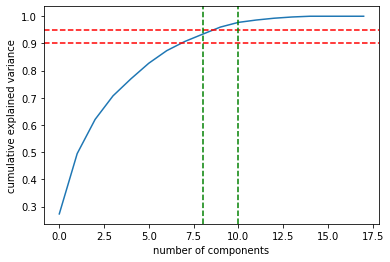

In [ ]:
# def PCA_withTerm(df):
# df.Date.astype({"string": "datetime64"})
# df = df.set_index('Date')
# print(new.shape)
df = df.apply(lambda x: (x-x.mean()) / x.std()).dropna(axis = 1)
# print(new.shape)

new = df.copy(deep = True)
pca = PCA().fit(new)

# print("Cumsum ratio: ", np.cumsum(pca.explained_variance_ratio_))

pca_90, pca_95 = PCA(0.90).fit(new), PCA(0.95).fit(new)
print("PCA >= 90% components: ", pca_90.n_components_, "\nPCA >= 95% components: ", pca_95.n_components_)

pca = PCA().fit(new)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(0.9, c='r', ls='--' )
plt.axhline(0.95, c='r', ls='--' )
plt.axvline(pca_90.n_components_, c='g', ls='--' )
plt.axvline(pca_95.n_components_, c='g', ls='--' )

n = (pca_90.n_components_ + pca_95.n_components_) // 2
pca = PCA(n_components = n)
pca.fit(new)
print("PCA explained variance: \n", pca.explained_variance_)
print("PCA explained variance ratio: \n", pca.explained_variance_ratio_)


projected = pca.fit_transform(new)
corr = [np.corrcoef(projected[:, 0], new[tick])[0, 1] for tick in new.columns]

data = pd.DataFrame({"Symbol": new.columns, "Corr": corr})
data = data.sort_values(by = 'Corr', ascending = False).reset_index(drop = True)
# data = data.merge(file[['Symbol',"Name", 'Sector']], how = 'left', on = 'Symbol')

# return data

KeyError: ignored